# Set Up

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Analisi Dati

In [ ]:
df = pd.read_csv('/content/Emotion_classify_Data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [ ]:
df.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [ ]:
df.tail()

,Comment,Emotion
5932,i begun to feel distressed for you,fear
5933,i left feeling annoyed and angry thinking that...,anger
5934,i were to ever get married i d have everything...,joy
5935,i feel reluctant in applying there because i w...,fear
5936,i just wanted to apologize to you because i fe...,anger


In [ ]:
df.describe()

,Comment,Emotion
count,5937,5937
unique,5934,3
top,i feel pretty tortured because i work a job an...,anger
freq,2,2000


Abbiamo dato una breve occhiata hai dati per vedere se erano pulita

In [ ]:
# Preprocessing
texts = df['Comment'].astype(str).values
labels = df['Emotion'].astype(str).values

Convertiamo ogni valore in stringa (nel caso ci siano valori non testuali).

Questo passaggio è il punto di partenza per trasformare un dataset testuale in un formato numerico che una rete neurale può comprendere e utilizzare per l’addestramento.

In [ ]:
# Codifica delle etichette testuali in numeri interi
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)


- LabelEncoder(): È uno strumento di scikit-learn che serve per convertire etichette testuali in numeri interi.

- fit_transform(labels): Analizza tutte le etichette presenti e assegna un numero intero univoco a ciascuna, poi applica questa codifica a tutto l’array labels.

Questo passaggio trasforma le emozioni testuali in numeri interi per permettere alla rete neurale di apprendere e classificare correttamente.

In [ ]:
# Tokenizzazione
tokenizer = Tokenizer(num_words=10000,)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, padding='post', maxlen=50)

Tokenizer(num_words=10000):

- Crea un oggetto Tokenizer di Keras, che tiene conto solo delle 10000 parole più frequenti nel dataset, ed ogni di esse verrà associata a un numero intero.

fit_on_texts(texts):
- Analizza tutti i testi per costruire un vocabolario.
Assegna un indice numerico a ogni parola (es. "happy" → 42).

texts_to_sequences(texts):

- Converte ogni frase in una sequenza di numeri interi.

pad_sequences(..., maxlen=50):

- Rende tutte le sequenze della stessa lunghezza (50 parole).
Se una frase è più corta, aggiunge zeri (0) alla fine (padding='post').
Se è più lunga, la tronca.

Questo blocco è fondamentale per preparare i dati testuali in modo che possano essere compresi da una rete neurale. È il ponte tra linguaggio umano e numeri.

In [ ]:
# Suddivisione in train, validazione e test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    padded, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)


Creazione di train, validation e test set

## prova 1

In [ ]:
# Costruzione del modello
num_classes = len(np.unique(labels_encoded))
model = Sequential([
    Embedding(input_dim=10000, output_dim=16, input_length=50), #20000
    GlobalAveragePooling1D(),
    Dropout(0.3), #0.5
    Dense(32, activation='relu'), #16
    Dense(num_classes, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   #optimizer=Adam(learning_rate=0.0001)  0.005

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


- num_classes= calcola il numero di classi distinte. È fondamentale perché l’ultimo layer del modello dovrà avere un neurone per ciascuna classe.
- Embettding: Considera le 10000 parole più frequenti, e ne rappresenta ogniuna con un vettore di 16 dimensioni. Ogni frase è stata "padded" a 50 parole.
- GlobalAveragePooling1D(): Serve a ridurre la dimensionalità e a ottenere una rappresentazione compatta della frase, indipendente dalla lunghezza effettiva.
- Dropout: è una tecnica di regolarizzazione: durante l’allenamento, spegne casualmente il 30% dei neuroni per evitare che il modello si adatti troppo ai dati di training (overfitting).
- Il layer è completamente connesso (dense) con 32 neuroni e funzione di attivazione ReLU, che introduce non linearità. Serve a combinare le informazioni apprese dagli embedding e a prepararle per la classificazione finale.
- Il layer di output, ha un neurone per ogni classe. Usa la funzione di attivazione softmax, che restituisce una distribuzione di probabilità: la somma delle uscite è 1, e ogni valore rappresenta la probabilità che l’input appartenga a quella classe.


model.compile:
- loss= 'sparse_categorical_crossentropy': adatta perchè abbiamo più classi
- optimizer='adam':algoritmo di ottimizzazione molto efficace e usato di default.
- metrics=['accuracy']: usiamo l'accuracy come metrica

In [ ]:
# Allenamento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=8, #10
    batch_size=32)  #128

Epoch 1/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3461 - loss: 1.0984 - val_accuracy: 0.3368 - val_loss: 1.0969
Epoch 2/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3682 - loss: 1.0954 - val_accuracy: 0.3421 - val_loss: 1.0908
Epoch 3/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4399 - loss: 1.0815 - val_accuracy: 0.6084 - val_loss: 1.0697
Epoch 4/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6212 - loss: 1.0379 - val_accuracy: 0.5558 - val_loss: 1.0359
Epoch 5/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7096 - loss: 0.9169 - val_accuracy: 0.6695 - val_loss: 0.8762
Epoch 6/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8087 - loss: 0.7128 - val_accuracy: 0.8158 - val_loss: 0.6953
Epoch 7/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9044 - loss: 0.4961 - val_accuracy: 0.8347 - val_loss: 0.5650
Epoch 8/8
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9399 - loss: 0.3482 - val_accuracy: 0.8674 - 

Allena il modello con  X_train, y_train e utilizza il X_val, y_val per convalidare i risultati dopo ogni epoca. Abbiamo fermato le epoche a 8 perchè dopo il modello diventava lineare. Il batch_size che indica quanti campioni (esempi) vengono usati in ogni aggiornamento dei pesi durante l'addestramento, l'abbiamo messo a 32 perché il dataset è di grandi dimensioni.

In [ ]:
#  Valutazione sul test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8522 - loss: 0.4847
Test Accuracy: 0.84


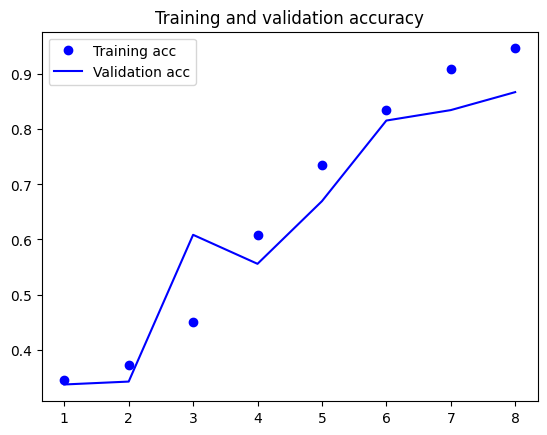

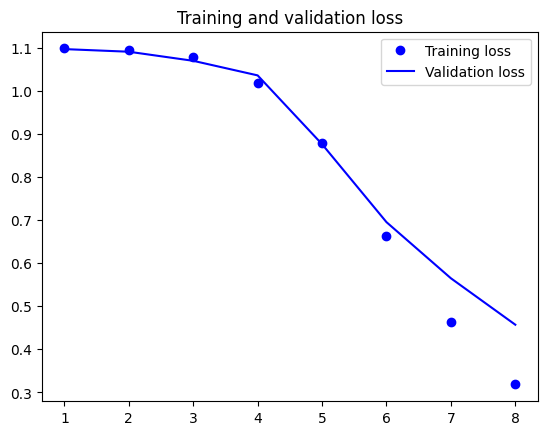

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## prova 2

In [ ]:
# Costruzione del modello
num_classes = len(np.unique(labels_encoded))
model = Sequential([
    Embedding(input_dim=20000, output_dim=16, input_length=50), #20000
    GlobalAveragePooling1D(),
    Dropout(0.5), #0.5
    Dense(16, activation='relu'), #16
    Dense(num_classes, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001)  , metrics=['accuracy'])   #optimizer=Adam(learning_rate=0.0001)  0.005

Adam è particolarmente adatto a il nostro tipo di dati (rumorosi e sparsi) perché adatta dinamicamente il passo di aggiornamento per ogni parametro, rendendo l’ottimizzazione più robusta.

Il learning rate basso aiuta a migliorare la precisione e a prevenire errori grossolani.

In [ ]:
# Allenamento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, #10
    batch_size=128)  #128

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.3394 - loss: 1.0986 - val_accuracy: 0.3316 - val_loss: 1.0987
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3464 - loss: 1.0985 - val_accuracy: 0.3347 - val_loss: 1.0986
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3487 - loss: 1.0984 - val_accuracy: 0.3547 - val_loss: 1.0985
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3457 - loss: 1.0984 - val_accuracy: 0.3516 - val_loss: 1.0985
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3546 - loss: 1.0984 - val_accuracy: 0.3716 - val_loss: 1.0984
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3499 - loss: 1.0984 - val_accuracy: 0.3421 - val_loss: 1.0983
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3630 - loss: 1.0982 - val_accuracy: 0.3453 - val_loss: 1.0983
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3549 - loss: 1.0984 - val_accuracy: 0.3400 - val_loss

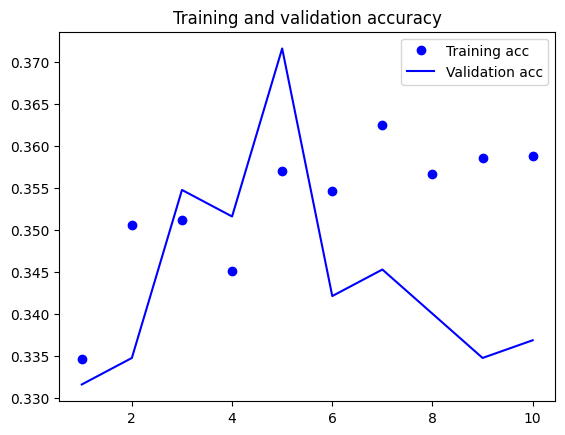

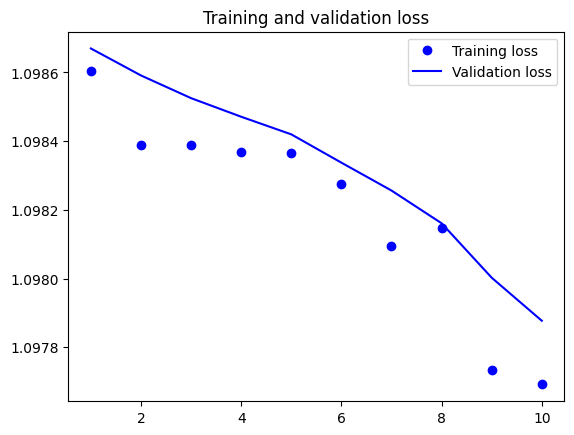

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## prova 3

In [ ]:
# Costruzione del modello
num_classes = len(np.unique(labels_encoded))
model = Sequential([
    Embedding(input_dim=20000, output_dim=16, input_length=50), #20000
    GlobalAveragePooling1D(),
    Dropout(0.5), #0.5
    Dense(16, activation='relu'), #16
    Dense(num_classes, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.005)  , metrics=['accuracy'])   #optimizer=Adam(learning_rate=0.0001)  0.005

In [ ]:
# Allenamento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, #10
    batch_size=64)  #128

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3313 - loss: 1.1009 - val_accuracy: 0.3621 - val_loss: 1.0947
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3615 - loss: 1.0934 - val_accuracy: 0.3600 - val_loss: 1.0837
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4204 - loss: 1.0675 - val_accuracy: 0.5147 - val_loss: 1.0010
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5346 - loss: 0.9353 - val_accuracy: 0.5547 - val_loss: 0.9042
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5565 - loss: 0.8790 - val_accuracy: 0.6463 - val_loss: 0.7225
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7011 - loss: 0.6429 - val_accuracy: 0.6853 - val_loss: 0.7749
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7575 - loss: 0.5566 - val_accuracy: 0.8189 - val_loss: 0.5310
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8318 - loss: 0.4025 - val_accuracy: 0.8568 - val_loss

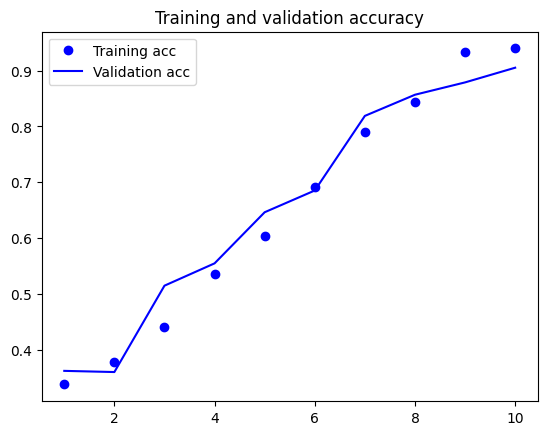

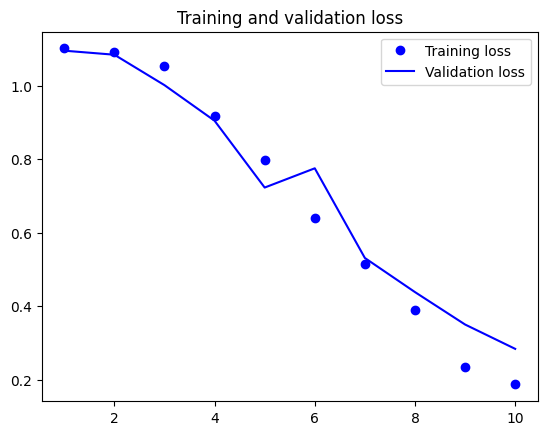

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## prova 4

In [ ]:
# Costruzione del modello
num_classes = len(np.unique(labels_encoded))
model = Sequential([
    Embedding(input_dim=20000, output_dim=16, input_length=50), #20000
    GlobalAveragePooling1D(),
    Dropout(0.5), #0.5
    Dense(16, activation='relu'), #16
    Dense(num_classes, activation='softmax')])
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.05)  , metrics=['accuracy'])   #optimizer=Adam(learning_rate=0.0001)  0.005

In [ ]:
# Allenamento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, #10
    batch_size=32)  #128

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3423 - loss: 1.1178 - val_accuracy: 0.3368 - val_loss: 1.0995
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2988 - loss: 1.1025 - val_accuracy: 0.3358 - val_loss: 1.0989
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3378 - loss: 1.1018 - val_accuracy: 0.3368 - val_loss: 1.0991
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3272 - loss: 1.1031 - val_accuracy: 0.3368 - val_loss: 1.0989
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3323 - loss: 1.1050 - val_accuracy: 0.3368 - val_loss: 1.1066
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3196 - loss: 1.1059 - val_accuracy: 0.3263 - val_loss: 1.1015
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3484 - loss: 1.1012 - val_accuracy: 0.3368 - val_loss: 1.0995
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3324 - loss: 1.1021 - val_accuracy: 0

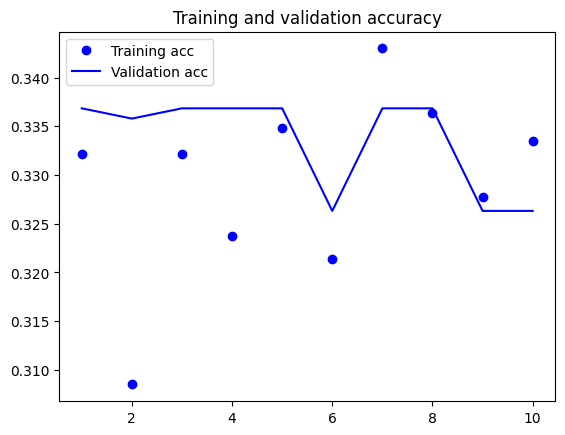

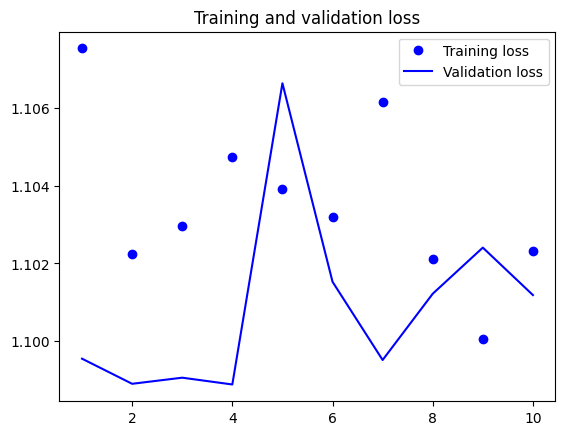

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()